In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
data_path = "../data/BPI_Challenge_2017.gzip"

# Event of interest: what to predict
event_of_interest = "A_Cancelled"  # O_Accepted

df_bpi= pd.read_parquet("../data/BPI_Challenge_2017.gzip")
df_bpi.rename(inplace=True, columns={"time:timestamp": "time", "case:concept:name": "case", "concept:name": "event"})
df_bpi["time"] = pd.to_datetime(df_bpi["time"], errors='coerce')

# Filtering on end events

In [3]:
# Group data by case_id and get start and end events
start_events = df_bpi.groupby('case')['event'].first()
end_events = df_bpi.groupby('case')['event'].last()

# Count occurrences of start and end events
start_event_counts = Counter(start_events)
end_event_counts = Counter(end_events)

# Combine results into a DataFrame
results = pd.DataFrame({
    'Start_Event_Count': pd.Series(start_event_counts),
    'End_Event_Count': pd.Series(end_event_counts)
}).fillna(0).astype(int)

# Display the results
print(results)
# We conclude that only O_Cancelled, W_Call after offers, W_Call incomplete files, W_validate_application
# Remove other traces makes the process more uniform. 

# This is what is done in the "filter_log" function below

                            Start_Event_Count  End_Event_Count
A_Create Application                    31509                0
A_Denied                                    0                1
O_Cancelled                                 0             4436
O_Returned                                  0                1
O_Sent (mail and online)                    0               15
O_Sent (online only)                        0                8
W_Assess potential fraud                    0              102
W_Call after offers                         0             9457
W_Call incomplete files                     0             4676
W_Complete application                      0              144
W_Personal Loan collection                  0                2
W_Shortened completion                      0                5
W_Validate application                      0            12662


# Bucketing starting sequences

Dictionary of Starting Sequences (Length 5) with Frequencies > 0:
{('A_Create Application', 'A_Submitted', 'W_Handle leads', 'W_Handle leads', 'W_Complete application'): 16780, ('A_Create Application', 'W_Complete application', 'W_Complete application', 'A_Concept', 'A_Accepted'): 7235, ('A_Create Application', 'A_Submitted', 'W_Handle leads', 'W_Handle leads', 'W_Handle leads'): 3621, ('A_Create Application', 'W_Complete application', 'W_Complete application', 'A_Concept', 'W_Complete application'): 462, ('A_Create Application', 'A_Concept', 'W_Complete application', 'W_Complete application', 'W_Complete application'): 1850, ('A_Create Application', 'A_Concept', 'W_Complete application', 'W_Complete application', 'A_Accepted'): 1539, ('A_Create Application', 'A_Submitted', 'W_Handle leads', 'W_Handle leads', 'W_Assess potential fraud'): 22}


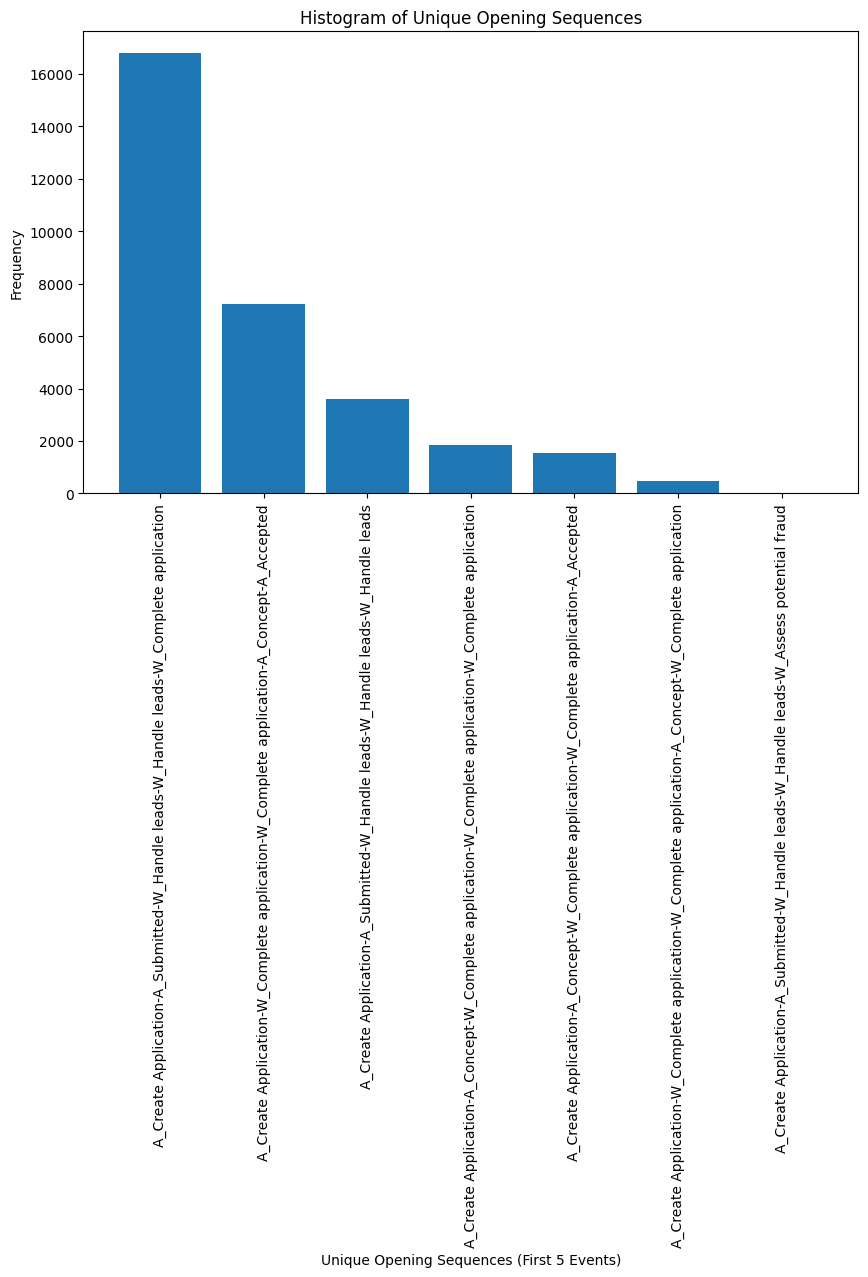

In [6]:
# Step 1: Group events by case_id
grouped = df_bpi.groupby('case')['event'].apply(list)

# Step 2: Extract the first 5 events
sequences = grouped.apply(lambda x: tuple(x[:5]) if len(x) >= 5 else None).dropna()

# Step 3: Count unique sequences
sequence_counts = Counter(sequences)

# Step 4: Filter sequences with frequency > 0 (all valid counts)
filtered_sequences = {seq: count for seq, count in sequence_counts.items() if count > 0}

# Step 5: Print results
print("Dictionary of Starting Sequences (Length 5) with Frequencies > 0:")
print(filtered_sequences)

# Step 6: Convert Counter to DataFrame for visualization
hist_data = pd.DataFrame(sequence_counts.items(), columns=['Sequence', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Step 5: Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(['-'.join(seq) for seq in hist_data['Sequence']], hist_data['Frequency'])
plt.xticks(rotation=90)
plt.xlabel('Unique Opening Sequences (First 5 Events)')
plt.ylabel('Frequency')
plt.title('Histogram of Unique Opening Sequences')
plt.show()

# Looking into other columns

In [26]:
df_bpi.columns

Index(['Action', 'org:resource', 'event', 'EventOrigin', 'EventID',
       'lifecycle:transition', 'time', 'case:LoanGoal', 'case:ApplicationType',
       'case', 'case:RequestedAmount', 'FirstWithdrawalAmount',
       'NumberOfTerms', 'Accepted', 'MonthlyCost', 'Selected', 'CreditScore',
       'OfferedAmount', 'OfferID'],
      dtype='object')

In [39]:
df_bpi[~df_bpi.Selected.isna()].NumberOfTerms

9           44.0
50          33.0
79         120.0
87         120.0
135         96.0
           ...  
1202122    120.0
1202124    127.0
1202148    120.0
1202202     77.0
1202254     77.0
Name: NumberOfTerms, Length: 42995, dtype: float64

In [30]:
df_bpi

,Action,org:resource,event,EventOrigin,EventID,lifecycle:transition,time,case:LoanGoal,case:ApplicationType,case,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202262,Deleted,User_1,W_Call after offers,Workflow,Workitem_1817549786,ate_abort,2017-01-06 06:33:02.212000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
1202263,Created,User_1,W_Call after offers,Workflow,Workitem_363876066,schedule,2017-01-06 06:33:02.221000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
1202264,statechange,User_28,A_Cancelled,Application,ApplState_1869071797,complete,2017-01-16 09:51:21.114000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,None
1202265,statechange,User_28,O_Cancelled,Offer,OfferState_420066181,complete,2017-01-16 09:51:21.139000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,None,NaN,None,NaN,NaN,Offer_1580299144


In [29]:
df_bpi["case:RequestedAmount"]

0          20000.0
1          20000.0
2          20000.0
3          20000.0
4          20000.0
            ...   
1202262    20000.0
1202263    20000.0
1202264    20000.0
1202265    20000.0
1202266    20000.0
Name: case:RequestedAmount, Length: 1202267, dtype: float64

In [31]:
df_bpi["case:ApplicationType"]

0          New credit
1          New credit
2          New credit
3          New credit
4          New credit
              ...    
1202262    New credit
1202263    New credit
1202264    New credit
1202265    New credit
1202266    New credit
Name: case:ApplicationType, Length: 1202267, dtype: object

In [ ]:
df_bpi["case:LoanGoal"]

0          Existing loan takeover
1          Existing loan takeover
2          Existing loan takeover
3          Existing loan takeover
4          Existing loan takeover
                    ...          
1202262          Home improvement
1202263          Home improvement
1202264          Home improvement
1202265          Home improvement
1202266          Home improvement
Name: case:LoanGoal, Length: 1202267, dtype: object

In [28]:
print(df_bpi[~df_bpi["case:RequestedAmount"].isna()])
df_bpi[~df_bpi["case:RequestedAmount"].isna()].event.unique()

              Action org:resource                   event  EventOrigin  \
0            Created       User_1    A_Create Application  Application   
1        statechange       User_1             A_Submitted  Application   
2            Created       User_1          W_Handle leads     Workflow   
3            Deleted       User_1          W_Handle leads     Workflow   
4            Created       User_1  W_Complete application     Workflow   
...              ...          ...                     ...          ...   
1202262      Deleted       User_1     W_Call after offers     Workflow   
1202263      Created       User_1     W_Call after offers     Workflow   
1202264  statechange      User_28             A_Cancelled  Application   
1202265  statechange      User_28             O_Cancelled        Offer   
1202266      Deleted      User_28     W_Call after offers     Workflow   

                       EventID lifecycle:transition  \
0        Application_652823628             complete   
1

array(['A_Create Application', 'A_Submitted', 'W_Handle leads',
       'W_Complete application', 'A_Concept', 'A_Accepted',
       'O_Create Offer', 'O_Created', 'O_Sent (mail and online)',
       'W_Call after offers', 'A_Complete', 'W_Validate application',
       'A_Validating', 'O_Returned', 'W_Call incomplete files',
       'A_Incomplete', 'O_Accepted', 'A_Pending', 'A_Denied', 'O_Refused',
       'O_Cancelled', 'A_Cancelled', 'O_Sent (online only)',
       'W_Assess potential fraud', 'W_Personal Loan collection',
       'W_Shortened completion '], dtype=object)

In [25]:
print(df_bpi[~df_bpi.CreditScore.isna()])
df_bpi[~df_bpi.CreditScore.isna()].event.unique()

          Action org:resource           event EventOrigin           EventID  \
9        Created      User_52  O_Create Offer       Offer   Offer_148581083   
50       Created      User_38  O_Create Offer       Offer  Offer_1669071500   
79       Created      User_19  O_Create Offer       Offer  Offer_1209840642   
87       Created      User_19  O_Create Offer       Offer   Offer_997411923   
135      Created      User_19  O_Create Offer       Offer  Offer_1319158006   
...          ...          ...             ...         ...               ...   
1202122  Created      User_84  O_Create Offer       Offer   Offer_682062790   
1202124  Created      User_84  O_Create Offer       Offer  Offer_1395096354   
1202148  Created      User_84  O_Create Offer       Offer  Offer_1445809476   
1202202  Created      User_84  O_Create Offer       Offer  Offer_1734870628   
1202254  Created      User_96  O_Create Offer       Offer  Offer_1580299144   

        lifecycle:transition                       

array(['O_Create Offer'], dtype=object)

In [27]:
print(df_bpi[~df_bpi.MonthlyCost.isna()])
df_bpi[~df_bpi.MonthlyCost.isna()].event.unique()

          Action org:resource           event EventOrigin           EventID  \
9        Created      User_52  O_Create Offer       Offer   Offer_148581083   
50       Created      User_38  O_Create Offer       Offer  Offer_1669071500   
79       Created      User_19  O_Create Offer       Offer  Offer_1209840642   
87       Created      User_19  O_Create Offer       Offer   Offer_997411923   
135      Created      User_19  O_Create Offer       Offer  Offer_1319158006   
...          ...          ...             ...         ...               ...   
1202122  Created      User_84  O_Create Offer       Offer   Offer_682062790   
1202124  Created      User_84  O_Create Offer       Offer  Offer_1395096354   
1202148  Created      User_84  O_Create Offer       Offer  Offer_1445809476   
1202202  Created      User_84  O_Create Offer       Offer  Offer_1734870628   
1202254  Created      User_96  O_Create Offer       Offer  Offer_1580299144   

        lifecycle:transition                       

array(['O_Create Offer'], dtype=object)

In [ ]:
# case:loangoal
# case:requestedamount
# life

In [19]:
df_bpi.MonthlyCost.dropna()

9          498.29
50         200.00
79         158.98
87         158.98
135        198.65
            ...  
1202122    154.11
1202124    150.00
1202148    106.46
1202202    450.00
1202254    297.81
Name: MonthlyCost, Length: 42995, dtype: float64

In [12]:
df_bpi.columns

Index(['Action', 'org:resource', 'event', 'EventOrigin', 'EventID',
       'lifecycle:transition', 'time', 'case:LoanGoal', 'case:ApplicationType',
       'case', 'case:RequestedAmount', 'FirstWithdrawalAmount',
       'NumberOfTerms', 'Accepted', 'MonthlyCost', 'Selected', 'CreditScore',
       'OfferedAmount', 'OfferID'],
      dtype='object')

In [15]:
df_bpi.EventOrigin.unique()

array(['Application', 'Workflow', 'Offer'], dtype=object)

In [17]:
df_bpi["case:RequestedAmount"]

0          20000.0
1          20000.0
2          20000.0
3          20000.0
4          20000.0
            ...   
1202262    20000.0
1202263    20000.0
1202264    20000.0
1202265    20000.0
1202266    20000.0
Name: case:RequestedAmount, Length: 1202267, dtype: float64

In [16]:
df_bpi["case:LoanGoal"]

0          Existing loan takeover
1          Existing loan takeover
2          Existing loan takeover
3          Existing loan takeover
4          Existing loan takeover
                    ...          
1202262          Home improvement
1202263          Home improvement
1202264          Home improvement
1202265          Home improvement
1202266          Home improvement
Name: case:LoanGoal, Length: 1202267, dtype: object

In [ ]:
# Bucket pre-offer model afgeleid door alle waardes die we nog niet weten
# Bucket post-offer model kan gebruik maken van alle laatste offer details
#    Want veel interessante info onder de "offer_created" event
#    Functie schrijven om deze info van nieuwste offer mee te nemen in opvolgende prefixes

# O_Create Offer Bucketing:

In [4]:
df = df_bpi.copy()
# Add a natural event order index within each case
df['event_index'] = df.groupby('case').cumcount()

# Filter to find 'O_Create Offer' and retrieve its event_index
o_create_offer_indices = df[df['event'] == 'O_Create Offer'][['case', 'event_index']]

# Display the results
print(o_create_offer_indices)

                           case  event_index
9         Application_652823628            9
50       Application_1691306052           10
79        Application_428409768            8
87        Application_428409768           16
135      Application_1746793196           19
...                         ...          ...
1202122  Application_2103458006            9
1202124  Application_2103458006           11
1202148    Application_59622033           12
1202202   Application_303923658            9
1202254  Application_1350494635            8

[42995 rows x 2 columns]


In [5]:
o_create_offer_indices.event_index.mean()

np.float64(12.113501569949994)